In [5]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [3]:
#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

HCP_pearson_homotopic_res_mean = (HCP_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              .assign(Diagnosis = "HCP")
                              )

### UCLA CNP ###
UCLA_CNP_Pearson_HoFC = pd.read_csv("../data/UCLA_CNP_Pearson_HoFC.csv")

UCLA_CNP_Pearson_HoFC_mean = (UCLA_CNP_Pearson_HoFC
                              .groupby(['Diagnosis', 'Base_Region'])['Mean_Pearson_R']
                                .mean()
                                .reset_index()
)

All_Pearson_HoFC = pd.concat([HCP_pearson_homotopic_res_mean, UCLA_CNP_Pearson_HoFC])
All_Pearson_HoFC_mean = All_Pearson_HoFC.groupby(["Diagnosis", "Base_Region"])['Mean_Pearson_R'].mean().reset_index()

Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning messages:
1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  side  region label              roi   Diagnosis Base_Region 
  <chr> <chr> <chr> <chr> <chr>  <glue>             <chr> <chr>     <chr>       
1 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Accumbens-area  <NA>  Control   Accumbens-a…
2 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Amygdala        <NA>  Control   Amygdala    
3 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Caudate         <NA>  Control   Caudate     
4 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Hippocampus     <NA>  Control   Hippocamp

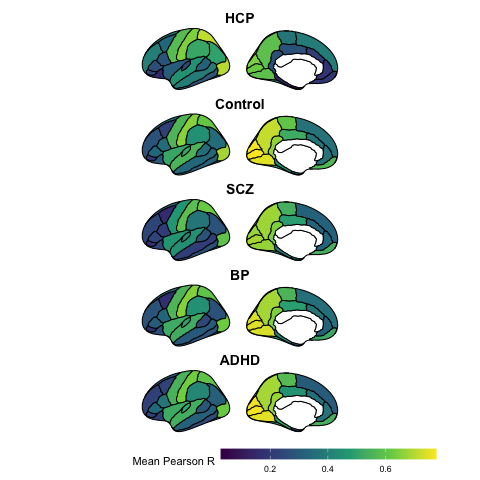

In [4]:
%%R -i All_Pearson_HoFC_mean

min_Pearson_R = min(All_Pearson_HoFC_mean$Mean_Pearson_R, na.rm=TRUE)
max_Pearson_R = max(All_Pearson_HoFC_mean$Mean_Pearson_R, na.rm=TRUE)

### Pearson FC in brain ###
dx_plot_list <- list() 
for (dx in c("HCP", "Control", "SCZ", "BP", "ADHD")) {
    dx_plot <- All_Pearson_HoFC_mean %>%
      filter(Diagnosis==dx) %>%
      mutate(label = glue("lh_{Base_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
            position = "stacked", colour = "black", hemisphere="left",
            linewidth=0.5) +
      theme_void() +
      ggtitle(dx) +
      labs(fill = "Mean Pearson R") +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
      scale_fill_viridis_c(na.value = "white", limits=c(min_Pearson_R, max_Pearson_R))
    dx_plot_list[[dx]] <- dx_plot
}

wrap_plots(dx_plot_list, ncol=1) +
       plot_layout(guides = "collect", axis_titles = "collect") & 
       theme(legend.position = 'bottom')

# ggsave("../plots/neuropsych_cases/UCLA_CNP_Pearson_HoFC_mean_brains.svg", width=4, height=8, dpi=300, units='in')

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



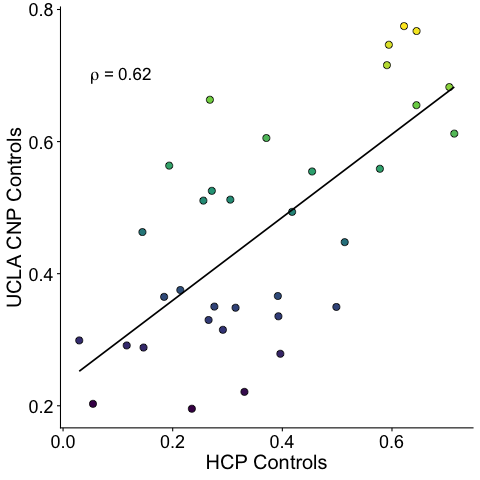

In [5]:
%%R -i All_Pearson_HoFC_mean 

## Is the mean Pearson-based HoFC comparable between controls in HCP vs UCLA CNP?
All_Pearson_HoFC_mean %>%
    filter(Diagnosis %in% c("HCP", "Control")) %>% 
    pivot_wider(names_from="Diagnosis", values_from="Mean_Pearson_R") %>%
    filter(!is.na(HCP)) %>%ggplot(data=., mapping=aes(x=HCP, y=Control, fill=Control)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c() +
    xlab("HCP Controls") +
    ylab("UCLA CNP Controls") +
    geom_smooth(method="lm", se=FALSE, color='black', linewidth=0.8) +
    # geom_abline(intercept=0, slope=1, color='black', linewidth=0.8) +
    # scale_x_continuous(limits=c(0, max_Pearson_R)) +
    # scale_y_continuous(limits=c(0, max_Pearson_R)) +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", aes(label=..r.label..), size=6, label.x=0.05, label.y=0.7) +
    theme(strip.background = element_blank(),
            strip.text.x = element_text(face='bold', size=18),
            axis.title = element_text(size=20),
            axis.text = element_text(size=18),
          legend.position = "none")
# ggsave("../plots/neuropsych_cases/Control_HCP100_vs_UCLA_CNP_Pearson_HoFC.svg", width=3.25, height=3, dpi=300, units='in')

In [10]:
control_HoFC_comparison = (All_Pearson_HoFC_mean
                           .query("Diagnosis in ['HCP', 'Control']")
                           .pivot(index='Base_Region', 
                                  columns='Diagnosis', 
                                  values='Mean_Pearson_R')
                            .dropna()
                           )

control_HoFC_comparison.head()

Diagnosis,Control,HCP
Base_Region,,
bankssts,0.348447,0.314670
caudalanteriorcingulate,0.375304,0.213912
caudalmiddlefrontal,0.221073,0.330858
cuneus,0.767371,0.644840
entorhinal,0.298947,0.029524


In [11]:
# Spin test

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "../data/fsaverage/lh.aparc.annot"
rh_dk = "../data/fsaverage/rh.aparc.annot"

# Convert the DK atlas to gifti format
# dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
dk_gifti = neuromaps.images.annot_to_gifti(lh_dk, background=None)
dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

# Fit a Parcellator object
dk_parc = Parcellater(dk_gifti, 'fsLR', resampling_target='parcellation', hemi='L')

# Satb2 first
rng = np.random.default_rng(seed=127)  # for reproducibility
UCLA_HoFC = control_HoFC_comparison['Control'].values
HCP_HoFC = control_HoFC_comparison['HCP'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

# Use SATB2 map to generate the nulls
spins_UCLA = nulls.alexander_bloch(UCLA_HoFC, atlas=atlas, parcellation=dk_gifti, density='164k',
                              n_perm=10000, seed=127)

# Step 4: Compare HoFC and SATB2 using the nulls
stat_UCLA_control, p_UCLA_control = stats.compare_images(HCP_HoFC, UCLA_HoFC, nulls=spins_UCLA, metric='spearmanr')

print(f"Observed control correlation between HCP/UCLA: {stat_UCLA_control:.3f}, p-value: {p_UCLA_control:.4f}")

Observed control correlation between HCP/UCLA: 0.624, p-value: 0.0005


## How do Pearson-based HoFC values differ between Controls vs. SCZ, BP, and ADHD?

In [6]:
%%R -i All_Pearson_HoFC_mean 

slopes <- All_Pearson_HoFC_mean %>% 
    filter(Diagnosis != "HCP") %>%
    pivot_wider(names_from="Diagnosis", values_from="Mean_Pearson_R") %>%
    pivot_longer(cols=c(-Base_Region, -Control), names_to="Diagnosis", values_to="Mean_Pearson_R") %>%
    mutate(Diagnosis = factor(Diagnosis, levels=c("SCZ", "BP", "ADHD"))) %>%
    group_by(Diagnosis) %>% 
       do({
       fit <- lm(Mean_Pearson_R ~ Control, data = .)
       data.frame(slope = coef(fit)[["Control"]])
       })

print(slopes)

# A tibble: 3 × 2
# Groups:   Diagnosis [3]
  Diagnosis slope
  <fct>     <dbl>
1 SCZ       0.906
2 BP        0.974
3 ADHD      1.02 


In [7]:
# Subtract mean Pearson R from ADHD, BP, or SCZ vs. Control
dx_HoFC_diffs_from_controls = (UCLA_CNP_Pearson_HoFC_mean
 .pivot(index='Base_Region', columns='Diagnosis', values='Mean_Pearson_R')
 .reset_index()
 .melt(id_vars=['Base_Region', 'Control'], var_name='Diagnosis', value_name='Mean_Pearson_R')
 .assign(DX_minus_Control = lambda x: x['Mean_Pearson_R'] - x['Control'])
 .drop_duplicates(subset=['Base_Region', 'Diagnosis', 'DX_minus_Control'])
 [['Base_Region', 'Diagnosis', 'DX_minus_Control']]
)

Joining with `by = join_by(Base_Region, Diagnosis)`


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



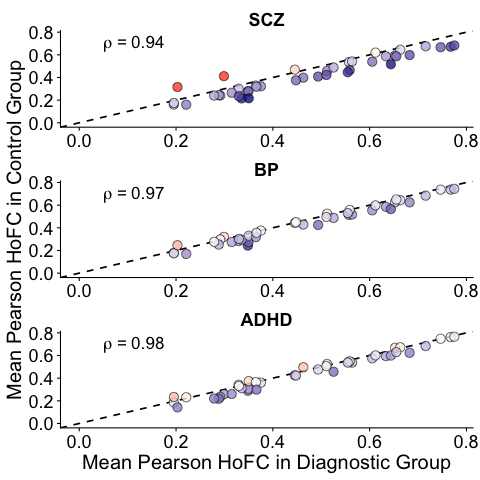

In [8]:
%%R -i All_Pearson_HoFC_mean,dx_HoFC_diffs_from_controls

min_diff = min(dx_HoFC_diffs_from_controls$DX_minus_Control)
max_diff = max(dx_HoFC_diffs_from_controls$DX_minus_Control)

All_Pearson_HoFC_mean %>% 
    filter(Diagnosis != "HCP100") %>%
    pivot_wider(names_from="Diagnosis", values_from="Mean_Pearson_R") %>%
    pivot_longer(cols=c(-Base_Region, -Control), names_to="Diagnosis", values_to="Mean_Pearson_R") %>%
    left_join(., dx_HoFC_diffs_from_controls) %>%
    filter(Diagnosis != 'HCP') %>%
    mutate(Diagnosis = factor(Diagnosis, levels=c("SCZ", "BP", "ADHD"))) %>%
    ggplot(data=., mapping=aes(x=Control, y=Mean_Pearson_R, fill=DX_minus_Control)) +
    geom_abline(intercept=0, slope=1, color='black', linewidth=0.8, linetype=2) +
    geom_point(color='black', shape=21, size=4, alpha=0.8) +
    xlab("Mean Pearson HoFC in Diagnostic Group") +
    ylab("Mean Pearson HoFC in Control Group") +
    facet_wrap(Diagnosis ~ ., scales="free", ncol=1) +
    scale_x_continuous(limits=c(0, max_Pearson_R)) +
    scale_y_continuous(limits=c(0, max_Pearson_R)) +
    scale_fill_gradient2(low = "#0F1F91", mid = "white", high = "red", midpoint=0, 
                           limits=c(min_diff, max_diff), na.value = "white") +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", aes(label=..r.label..), size=6, label.x=0.05, label.y=0.7) +
    theme(strip.background = element_blank(),
            strip.text.x = element_text(face='bold', size=18),
            axis.title = element_text(size=20),
            axis.text = element_text(size=18),
          legend.position = "none")

# ggsave("../plots/neuropsych_cases/UCLA_CNP_Pearson_HoFC_dx_vs_control_scatters.svg", width=3, height=8, dpi=300, units='in')

Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning messages:
1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  side  region label              roi   Base_Region  Diagnosis
  <chr> <chr> <chr> <chr> <chr>  <glue>             <chr> <chr>        <chr>    
1 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Accumbens-area  <NA>  Accumbens-a… ADHD     
2 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Amygdala        <NA>  Amygdala     ADHD     
3 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Caudate         <NA>  Caudate      ADHD     
4 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Hippocampus     <NA>  Hippocampus  ADHD     
5 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Pallidum        <NA>  Pallidum     ADHD     
6 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Putamen         <NA>  Putamen      ADHD     
7 

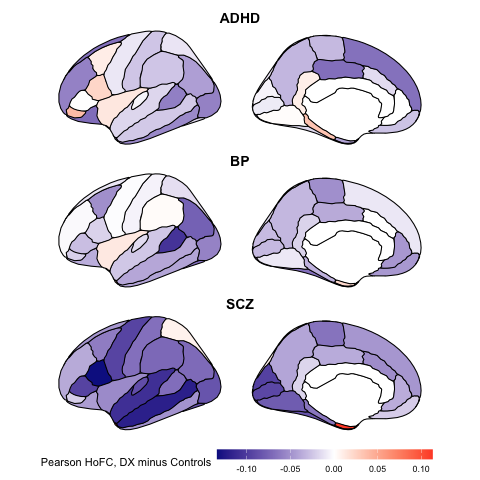

In [9]:
%%R -i dx_HoFC_diffs_from_controls

min_diff = min(dx_HoFC_diffs_from_controls$DX_minus_Control)
max_diff = max(dx_HoFC_diffs_from_controls$DX_minus_Control)

### Pearson FC in brain ###
dx_plot_list <- list() 
for (dx in unique(dx_HoFC_diffs_from_controls$Diagnosis)) {
    dx_plot <- dx_HoFC_diffs_from_controls %>%
      filter(Diagnosis==dx) %>%
      mutate(label = glue("lh_{Base_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      ggseg(atlas = dk, mapping = aes(fill = DX_minus_Control),
            position = "stacked", colour = "black", hemisphere="left",
            linewidth=0.5) +
      theme_void() +
      ggtitle(dx) +
      labs(fill = "Pearson HoFC, DX minus Controls") +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradient2(low = "#0F1F91", mid = "white", high = "red", midpoint=0, 
                           limits=c(min_diff, max_diff), na.value = "white")
    dx_plot_list[[dx]] <- dx_plot
}

wrap_plots(dx_plot_list, ncol=1) +
       plot_layout(guides = "collect", axis_titles = "collect") & 
       theme(legend.position = 'bottom')

# ggsave("../plots/neuropsych_cases/UCLA_CNP_Pearson_HoFC_dx_vs_control_brains.svg", width=4, height=6, dpi=300, units='in')